# Importing Libraries 

In [1]:
%load_ext nb_black
import re
import numpy as np  # for large and multi-dimensional arrays
import pandas as pd  # for data manipulation and analysis
import nltk  # Natural language processing tool-kit

from nltk.corpus import stopwords  # Stopwords corpus
from nltk.stem import PorterStemmer  # Stemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer  # For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF

import re, string, unicodedata  # Import Regex, string and unicodedata.
import contractions  # Import contractions library.
from bs4 import BeautifulSoup  # Import BeautifulSoup.

import numpy as np  # Import numpy.
import pandas as pd  # Import pandas.
import nltk  # Import Natural Language Tool-Kit.

from nltk.corpus import stopwords  # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer  # Import Lemmatizer.
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.ensemble import RandomForestClassifier  # Import Random forest Classifier
from sklearn.metrics import classification_report  # Import Classification report
from sklearn.model_selection import cross_val_score

# to ignore warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Reading the Dataset

In [2]:
# Loading data into pandas dataframe
data = pd.read_csv("Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<IPython.core.display.Javascript object>

# Exploratory Data Analysis

In [3]:
data.shape  # print shape of data.

(14640, 15)

<IPython.core.display.Javascript object>

In [4]:
data.info()  # information of all columns in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

<IPython.core.display.Javascript object>

In [5]:
data["airline"].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

<IPython.core.display.Javascript object>

- There are 6 airlines represented in this data set, I wanted to make sure before I go further so I know what to expect during my visualization step. 

In [6]:
data.isnull().sum(axis=0)  # Check for NULL values.

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

<IPython.core.display.Javascript object>

- The dataset posesses multiple missing data values. We will be removing many of these columns anyways as they will not add any value to our eventual model. 
- Most concerning values to me are the 5,462 in the "Negative Reason" column. It is hard to take a negative criticism seriously if there is no reason for it. Most people when leaving a negative review have no problem letting you know why they are so upset.
- The only columns we care about are the "airline_sentiment" and "text" columns, both of which have no missing values. This means we do not need to worry about any null values in this exercise. 

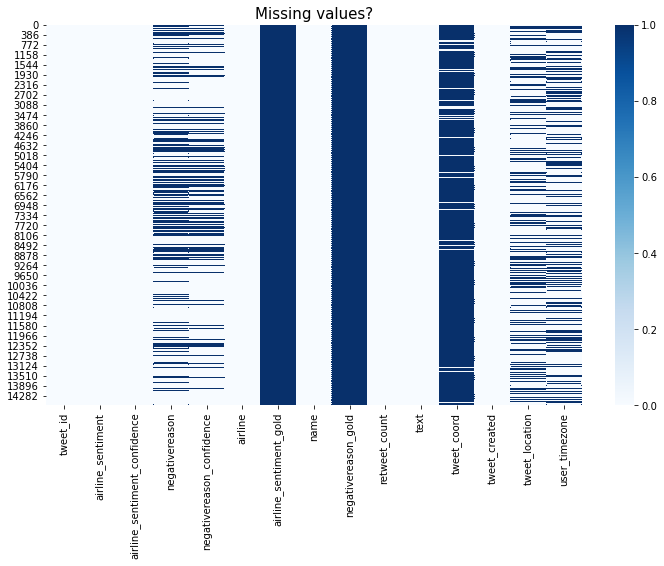

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(12, 7))
sns.heatmap(data.isnull(), cmap="Blues")  # Visualization of missing value using heatmap
plt.title("Missing values?", fontsize=15)
plt.show()

- We can tell from the null values above and this graph that 'Airline Sentiment Gold', 'Tweet Coord', and 'Negative Reason Gold' have so many missing values, it is like they dont exist.
- The lines in the above heatmap will visualize the location of missing values (i.e. the missing value indexes in the dataframe).

## Sentiment Analysis

In [8]:
data["airline_sentiment"].unique()  # check the labels

array(['neutral', 'positive', 'negative'], dtype=object)

<IPython.core.display.Javascript object>

In [9]:
data["airline_sentiment"].value_counts()  # check the count of each labels

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
sns.set(rc={"figure.figsize": (15, 15)})

<IPython.core.display.Javascript object>

### Distribution of all Tweets Among Each Airline in Relation to Sentiment

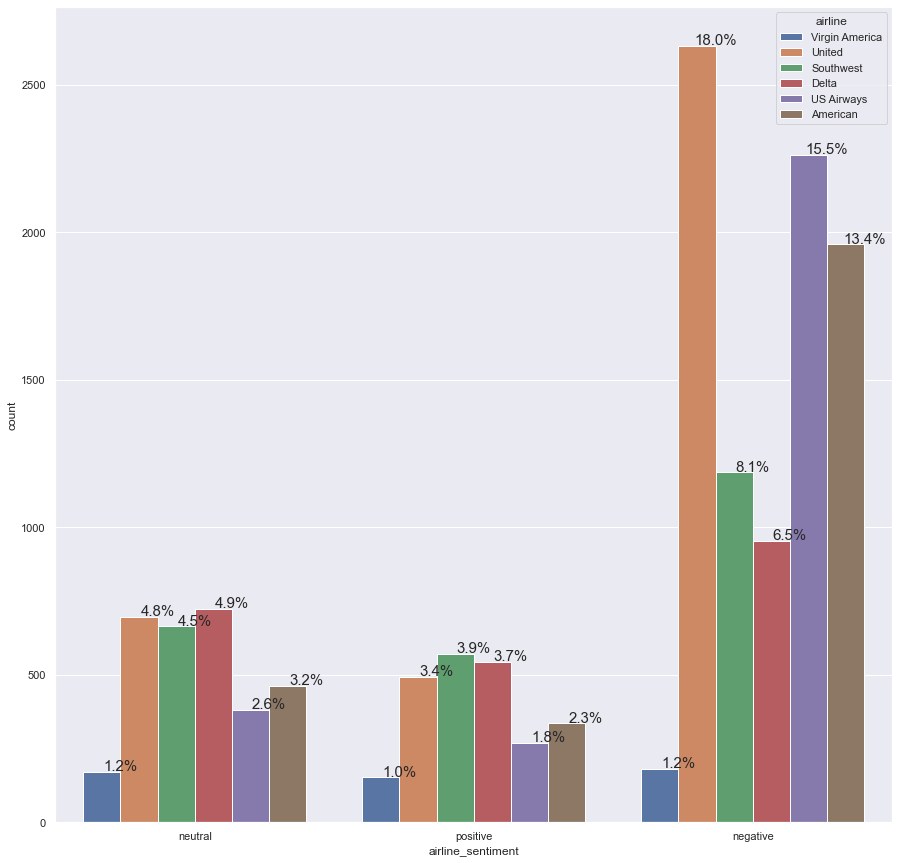

<IPython.core.display.Javascript object>

In [11]:
# plot the distribution of the class label
def bar_plot(data, feature):
    plot = sns.countplot(x=feature, data=data, hue="airline")
    total = len(data)
    for p in plot.patches:
        percentage = "{:.1f}%".format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()
        plot.annotate(
            percentage,
            (x, y),
            ha="center",
            va="center",
            size=15,
            xytext=(0, 5),
            textcoords="offset points",
        )
    plt.show()


bar_plot(data, "airline_sentiment")

- It seems that across all tweets, customers had a negative experience with the airlines in general. 
- United, US Airways, and American Airlines had the largest number of negative tweets sent about them.
- This graph shows even more how much more people are willing to express negative feelings than positive. 

### Distribution of all Tweets Among Each Airline in Relation to Negative Sentiment Reason

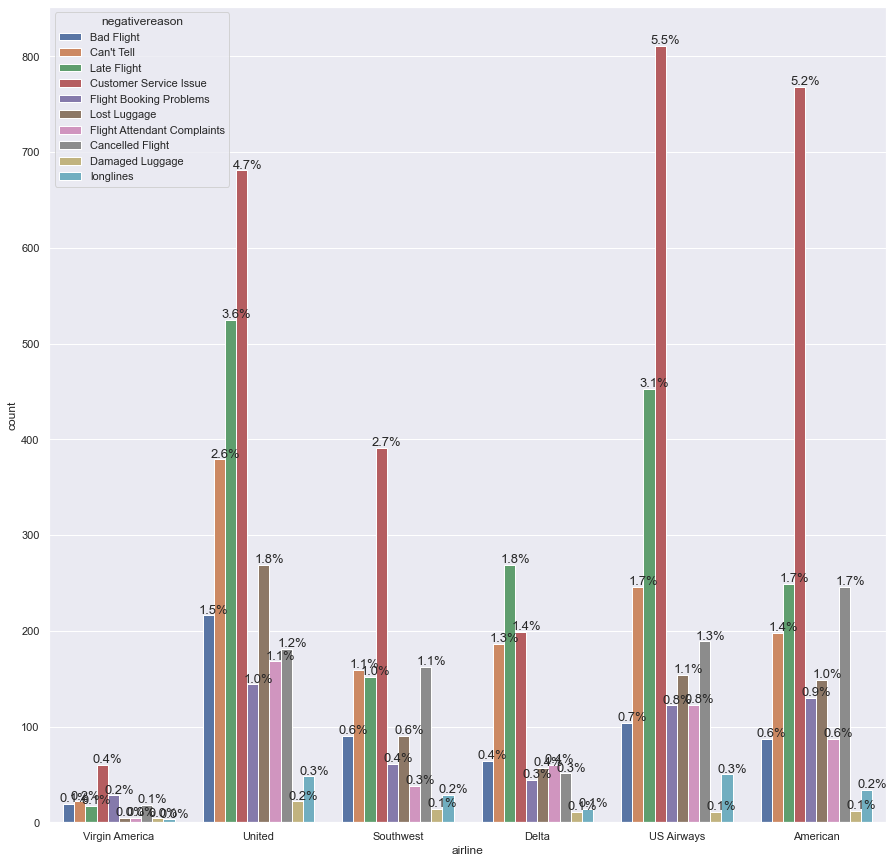

<IPython.core.display.Javascript object>

In [12]:
# plot the distribution of the class label
def bar_plot(data, feature):
    plot = sns.countplot(x=feature, data=data, hue="negativereason")
    total = len(data)
    for p in plot.patches:
        percentage = "{:.1f}%".format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()
        plot.annotate(
            percentage,
            (x, y),
            ha="center",
            va="center",
            size=13,
            xytext=(0, 5),
            textcoords="offset points",
        )
    plt.show()


bar_plot(data, "airline")

- Customer Service troubles seem to be the biggest reason for a negative tweet in five of the six airlines.
- Late flight comes in as the second most common reason for a negative tweet.

### Word Cloud for Negative Reviews

In [13]:
from wordcloud import WordCloud, STOPWORDS

<IPython.core.display.Javascript object>

In [14]:
negative_tweets = data[data["airline_sentiment"] == "negative"]
words = " ".join(negative_tweets["text"])
cleaned_word = " ".join([word for word in words.split()])

<IPython.core.display.Javascript object>

In [15]:
wordcloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", width=3000, height=2500
).generate(cleaned_word)

<IPython.core.display.Javascript object>

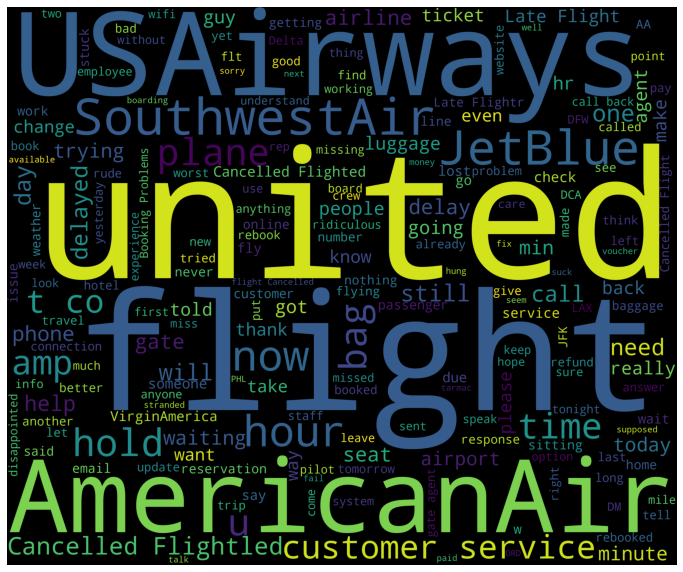

<IPython.core.display.Javascript object>

In [16]:
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

- Some obvious negative words I can see are "cancelled flight", "stuck", "waiting", "late flight", "ridiculous already", "delay", to name a few.
- Something else that is interesting is that multiple airlines are listed in big letters - "United", "USA Airways", "AmericanAir" - these are also the airlines with the most number of negative tweets.
- One strange thing about the word cloud is that we have "JetBlue" in the middle of our cloud, but they aren't one of our 6 airlines, which means people are mentioning them in our tweets while mentioning some other airline. 

### Word Cloud for Positive Reviews

In [17]:
positive_tweets = data[data["airline_sentiment"] == "positive"]
words = " ".join(positive_tweets["text"])
cleaned_word = " ".join([word for word in words.split()])

<IPython.core.display.Javascript object>

In [18]:
wordcloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", width=3000, height=2500
).generate(cleaned_word)

<IPython.core.display.Javascript object>

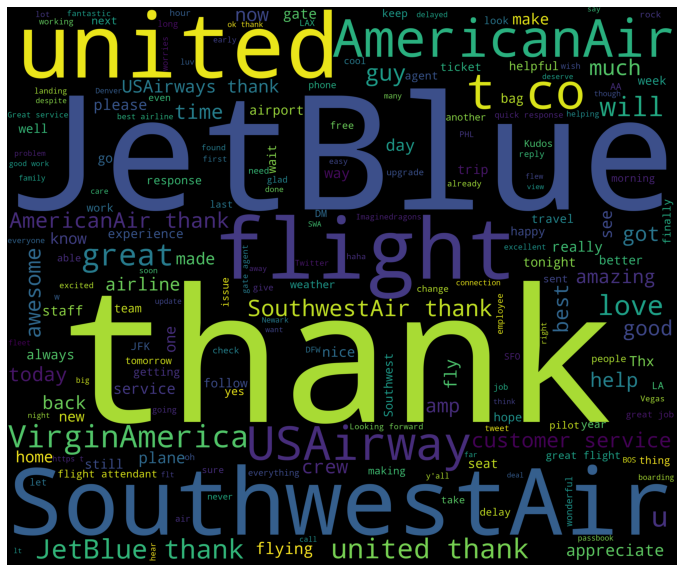

<IPython.core.display.Javascript object>

In [19]:
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

- Again, words like "SouthwestAir", "AmericanAir", "United" are represented. This is not surprising. These are huge airlines we are talking about which means they will always have happy customers AND upset customers. 
- What surprises me again is that "JetBlue" is huge in this word cloud, meaning people were clearly praising them on twitter, maybe they were comparing them to our other 6 airlines?
- Normal words that you would expect to show up on a positive word cloud are also present. These include "Thank", "best", "great", "love", "amazing", "appreciate".

# Understanding of Data Columns

In [20]:
# Create a copy of the data unless something goes wrong
df = data.copy()

<IPython.core.display.Javascript object>

In [21]:
# Eliminate all columns except for "text" and "airline_sentiment"

df.drop(
    [
        "tweet_id",
        "airline_sentiment_confidence",
        "negativereason",
        "negativereason_confidence",
        "airline",
        "airline_sentiment_gold",
        "name",
        "negativereason_gold",
        "retweet_count",
        "tweet_coord",
        "tweet_created",
        "tweet_location",
        "user_timezone",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

In [22]:
df.shape

(14640, 2)

<IPython.core.display.Javascript object>

- Data now has 14,640 rows and 2 columns

In [23]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<IPython.core.display.Javascript object>

# Data Pre - Processing

### Removal of HTTP Tags

In [24]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


df["text"] = df["text"].apply(lambda x: strip_html(x))
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<IPython.core.display.Javascript object>

### Expanding Contractions

In [25]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df["text"] = df["text"].apply(lambda x: replace_contractions(x))
df.head()


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...


<IPython.core.display.Javascript object>

### Removing the Numbers

In [26]:
# remove the numericals present in the text
def remove_numbers(text):
    text = re.sub(r"\d+", "", text)
    return text


df["text"] = df["text"].apply(lambda x: remove_numbers(x))
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...


<IPython.core.display.Javascript object>

### Tokenization of the Tweets

In [27]:
df["text"] = df.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1)
df.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, com..."
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, is, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, is, a, really, big..."


<IPython.core.display.Javascript object>

### Removal of Non Ascii characters

In [28]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []  # Create empty list to store pre-processed words.
    for word in words:
        new_word = (
            unicodedata.normalize("NFKD", word)
            .encode("ascii", "ignore")
            .decode("utf-8", "ignore")
        )
        new_words.append(new_word)  # Append processed words to new list.
    return new_words


df["text"] = df["text"].apply(lambda x: remove_non_ascii(x))
df.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, com..."
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, is, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, is, a, really, big..."


<IPython.core.display.Javascript object>

### Removal of Special Characters and Punctuations

In [29]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r"[^\w\s]", "", word)
        if new_word != "":
            new_words.append(new_word)
    return new_words

<IPython.core.display.Javascript object>

### Removal of Stopwords

In [30]:
stopwords = stopwords.words("english")
stopwords = list(set(stopwords))


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

<IPython.core.display.Javascript object>

### Converting to Lowercase

In [31]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

<IPython.core.display.Javascript object>

### Lemmatization

In [32]:
lemmatizer = WordNetLemmatizer()


def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos="v"))
    return new_words

<IPython.core.display.Javascript object>

### Putting All Together/Joining the Words

In [33]:
def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return " ".join(words)


df["text"] = df.apply(lambda row: normalize(row["text"]), axis=1)

<IPython.core.display.Javascript object>

In [34]:
df.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience ...
2,neutral,virginamerica today must mean need take anothe...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


<IPython.core.display.Javascript object>

- We now have text that is ready to be processed

# Vectorization

### Copying the Dataset Again

In [35]:
df2 = df.copy()

<IPython.core.display.Javascript object>

### Count Vectorization

In [36]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

Count_vec = CountVectorizer(
    max_features=500
)  # Keep only 500 features as number of features will increase the processing time.
data_features = Count_vec.fit_transform(df["text"])

data_features = data_features.toarray()  # Convert the data features to array.

<IPython.core.display.Javascript object>

In [37]:
data_features.shape  # Shape of the feature vector

(14640, 500)

<IPython.core.display.Javascript object>

### TFDIFVectorizer 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=500)
data_features2 = tfidf_vect.fit_transform(df2["text"])

data_features2 = data_features2.toarray()

data_features2.shape  # feature shape

(14640, 500)

<IPython.core.display.Javascript object>

# Modeling

### Count Vectorizer Model

In [39]:
X = data_features

y = data.airline_sentiment

<IPython.core.display.Javascript object>

In [40]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

<IPython.core.display.Javascript object>

In [41]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100, 400, 100).tolist()
base_ln

[100, 200, 300]

<IPython.core.display.Javascript object>

In [42]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators=b)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

<IPython.core.display.Javascript object>

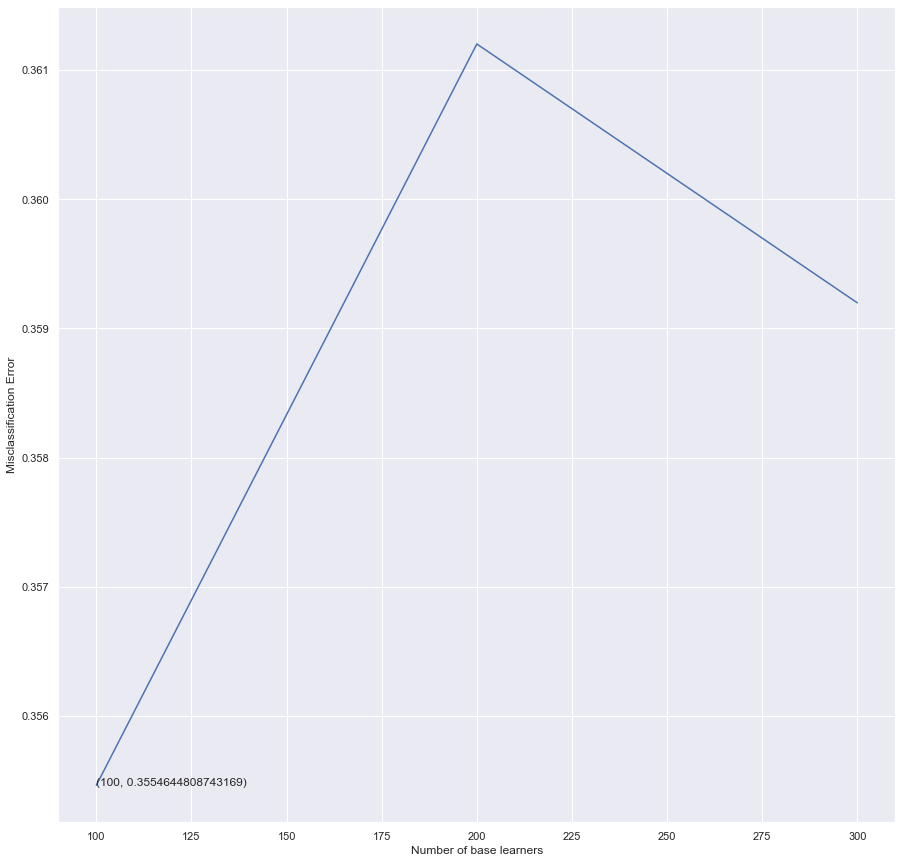

<IPython.core.display.Javascript object>

In [43]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]  # error corresponds to each nu of estimator
optimal_learners = base_ln[
    error.index(min(error))
]  # Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(
    base_ln, error
)  # Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate("(%s, %s)" % xy, xy=xy, textcoords="data")
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

- The misclassification error seems to steadily increase as the number of base learners increase, until about 200 learners, when the error starts to decline. 

In [44]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators=optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(
    classification_report(
        y_test,
        count_vectorizer_predicted,
        target_names=["Negative", "Neutral", "Positive"],
    )
)
print("Accuracy of the model is : ", accuracy_score(y_test, count_vectorizer_predicted))

              precision    recall  f1-score   support

    Negative       0.85      0.88      0.86      2627
     Neutral       0.48      0.42      0.44       577
    Positive       0.64      0.61      0.63       456

    accuracy                           0.77      3660
   macro avg       0.66      0.64      0.65      3660
weighted avg       0.77      0.77      0.77      3660

Accuracy of the model is :  0.7734972677595628


<IPython.core.display.Javascript object>

[[2310  213  104]
 [ 282  241   54]
 [ 123   53  280]]


<AxesSubplot:>

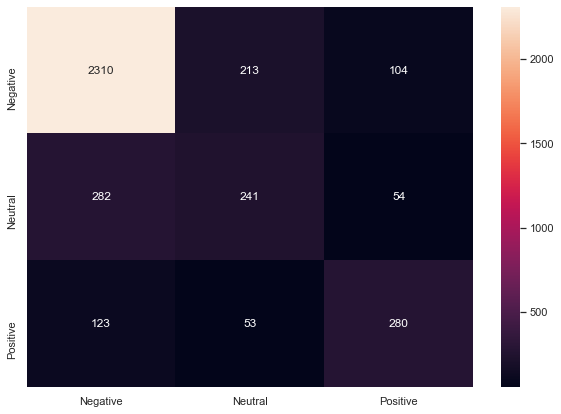

<IPython.core.display.Javascript object>

In [45]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, count_vectorizer_predicted)

print(conf_mat)

df_cm = pd.DataFrame(
    conf_mat,
    index=[i for i in ["Negative", "Neutral", "Positive"]],
    columns=[i for i in ["Negative", "Neutral", "Positive"]],
)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="g")

- The model predicts values pretty well. I think it has the hardest time with neutral tweets, most likely because language and sarcasm can play a huge role on twitter. Without an extremely extensive model, it would be very hard to truly predict all neutral tweets.

- This model returned a 78% accuracy, passing our threshold, meaning it would be passable as something we could use in real life to examine these tweets.

thank,usairways,delay,great,jetblue,http,flight,unite,love,southwestair,get,hold,awesome,bag,hours,cancel,go,fly,please,time,would,virginamerica,amaze,wait,hour,make,help,best,need,service,good,customer,plane,airline,one,say,us,like,know,call,
 
 


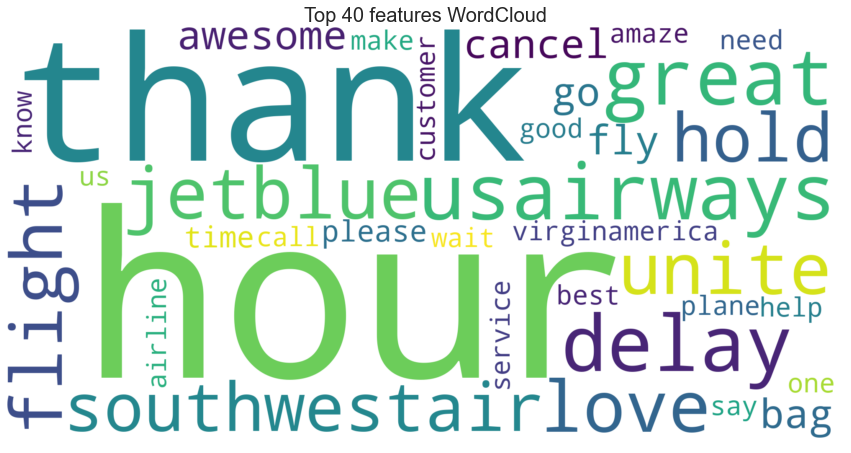

<IPython.core.display.Javascript object>

In [46]:
all_features = (
    Count_vec.get_feature_names()
)  # Instantiate the feature from the vectorizer
top_features = (
    ""  # Addition of top 40 feature into top_feature after training the model
)
feat = clf.feature_importances_
features = np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features += all_features[i]
    top_features += ","

print(top_features)

print(" ")
print(" ")

from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color="white", colormap="viridis", width=2000, height=1000
).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.figure(1, figsize=(14, 11), frameon="equal")
plt.title("Top 40 features WordCloud", fontsize=20)
plt.axis("off")
plt.show()

- These represent the words that our most present in our processed text across all tweets. Hour clearly stands out, perhaps pertaining to wait times. USAirways is also large, which as before we have seen is high in customer complaints (at least in tweet form). The words "hour", "delay", "hold", "cancel", "thank", "please", and "bag" all stand out for me.

### TFDIFVectorizer Model

In [47]:
X = data_features2

y = data.airline_sentiment

<IPython.core.display.Javascript object>

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

<IPython.core.display.Javascript object>

In [49]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100, 400, 100).tolist()
base_ln

[100, 200, 300]

<IPython.core.display.Javascript object>

In [50]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators=b)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

<IPython.core.display.Javascript object>

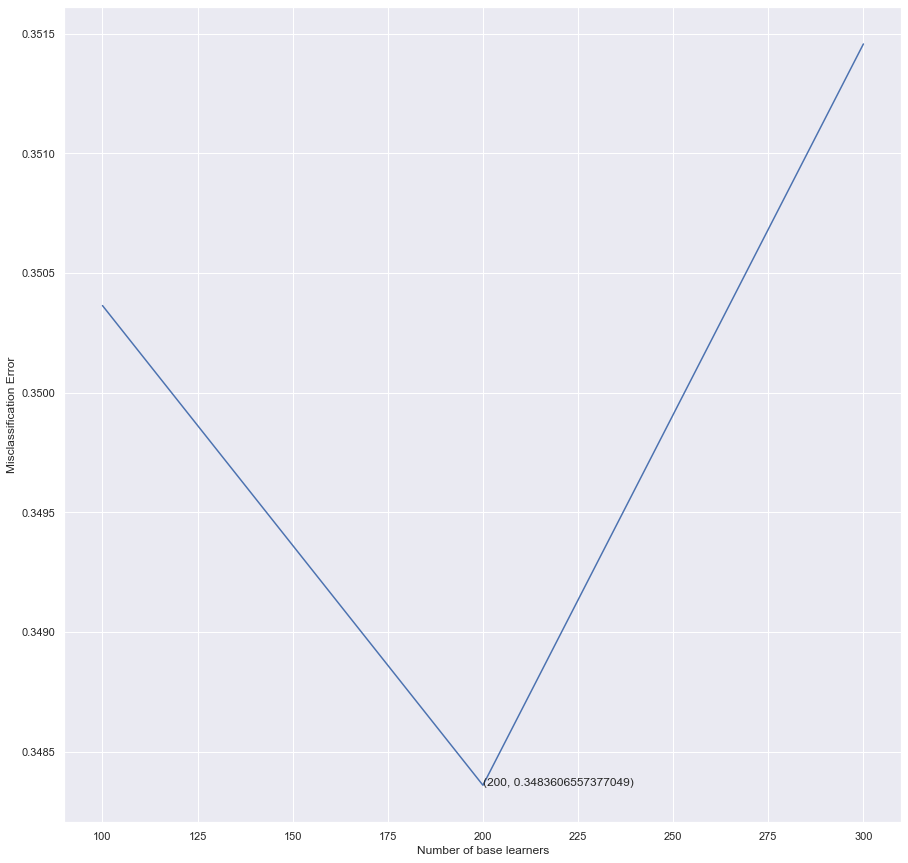

<IPython.core.display.Javascript object>

In [51]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]  # error corresponds to each nu of estimator
optimal_learners = base_ln[
    error.index(min(error))
]  # Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(
    base_ln, error
)  # Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate("(%s, %s)" % xy, xy=xy, textcoords="data")
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

- This model's missclassification error seems to go down as the number of base learners increases until it hits 200 learners, then it starts to rise again. At 200 learners, the missclassification error is 0.3483.

In [52]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators=optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(
    classification_report(
        y_test, tf_idf_predicted, target_names=["Negative", "Neutral", "Positive"]
    )
)
print("Accuracy of the model is : ", accuracy_score(y_test, tf_idf_predicted))

              precision    recall  f1-score   support

    Negative       0.81      0.94      0.87      2627
     Neutral       0.52      0.20      0.29       577
    Positive       0.69      0.57      0.62       456

    accuracy                           0.78      3660
   macro avg       0.67      0.57      0.59      3660
weighted avg       0.75      0.78      0.75      3660

Accuracy of the model is :  0.7797814207650273


<IPython.core.display.Javascript object>

[[2481   75   71]
 [ 417  114   46]
 [ 167   30  259]]


<AxesSubplot:>

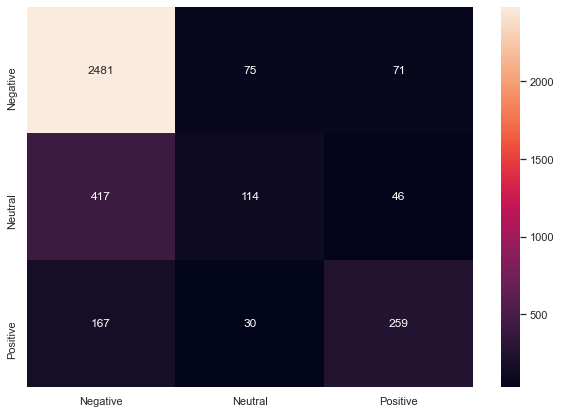

<IPython.core.display.Javascript object>

In [53]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(
    conf_mat,
    index=[i for i in ["Negative", "Neutral", "Positive"]],
    columns=[i for i in ["Negative", "Neutral", "Positive"]],
)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="g")

- This model is also predicting the Neutral class the worst, but it is still performing somewhat decent, with a weighted F1 score of 0.75
- This model's accuracy of 78%, which passes our 75% threshhold.

thank, jetblue, southwestair, unite, http, usairways, flight, great, virginamerica, delay, love, get, awesome, cancel, hours, hold, fly, bag, amaze, please, best, good, dm, would, make, need, wait, help, time, follow, hour, service, go, know, tomorrow, us, customer, airline, hi, much, 
 
 


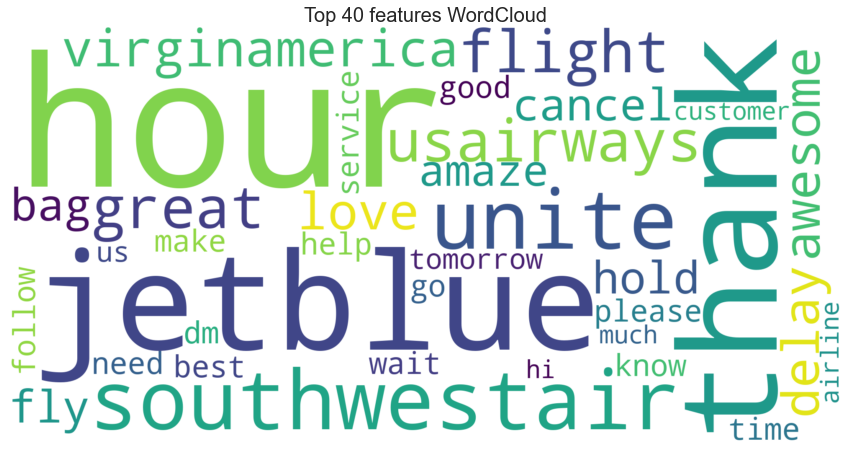

<IPython.core.display.Javascript object>

In [54]:
all_features = (
    tfidf_vect.get_feature_names()
)  # Instantiate the feature from the vectorizer
top_features = (
    ""  # Addition of top 40 feature into top_feature after training the model
)
feat = clf.feature_importances_
features = np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features += all_features[i]
    top_features += ", "

print(top_features)

print(" ")
print(" ")

from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color="white", colormap="viridis", width=2000, height=1000
).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.figure(1, figsize=(14, 11), frameon="equal")
plt.title("Top 40 features WordCloud", fontsize=20)
plt.axis("off")
plt.show()

- Very similar word cloud to the first model. Although now Southwestair and virginamerica are bigger. Jetblue is also present which again makes me wonder why so many tweets mentioned this airline that we did not study. There must be lots of tweets comparing them to the 6 airlines we were looking at. The words "hour", "delay", "thank", "cancel", "help", "awesome" all stand out.

# Summary

- Our goal was to build a model for text-classification, based on the varation of sentiment among tweets made about certain airlines.
- I preprocessed the data using various techniques and libraries. I also created a word cloud plot based on the positive and negative reviews of the airlines in question.
- Our model was based off the tweets sent about 6 top airlines.
- I vectorized my preprocessed data to turn the text into numbers in order to feed them into two types of models. 
- I trained both models and optimized the parameters in order to obtain a passable accuracy (75%). Both of my models achieved this. 
- Both models achieved similar results, around 78% accuracy.
- This was a relatively small sample size, with only 500 features, meaning if there was a larger sample size and more features used, it would be much easier to increase the accuracy of the models. This was done to speed up processing time of the models.
- Using different pre-processing techniques could improve the model accuracy as well - such as using stemming rather than lemmatization, not eliminating certain english stopwords (specifically ones that deal with contractions), and keeping contractions in the dataset. I chose to remove contractions to clean the data as much as I could, but it is possible that removing them could have hurt the accuracy of the model since our goal was to observe the sentiment of the tweets, many of which were negative.